# Feature distributions

* Which features should be translated to log
* How features correlate
* PCA of features

## 1 Setup

Flags and settings

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES_V1 = ['frequency', 'aoa', 'clustering', 'phonemes_count', 'synonyms_count']
PAPER_FEATURES_V2 = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count',
                     'orthographical_density']

Imports

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.features import SubstitutionFeaturesMixin

PAPER_FEATURE_NAMES_V1 = [SubstitutionFeaturesMixin._transformed_feature(feature).__doc__
                          for feature in PAPER_FEATURES_V1]
PAPER_FEATURE_NAMES_V2 = [SubstitutionFeaturesMixin._transformed_feature(feature).__doc__
                          for feature in PAPER_FEATURES_V2]

First build our data

In [3]:
words = set()
for feature in SubstitutionFeaturesMixin.__features__:
    words.update(getattr(SubstitutionFeaturesMixin, '_' + feature)())

words = sorted(words)
data = dict((feature, np.zeros(len(words)))
            for feature in SubstitutionFeaturesMixin.__features__)
tdata = dict((SubstitutionFeaturesMixin._transformed_feature(feature).__doc__,
              np.zeros(len(words)))
             for feature in SubstitutionFeaturesMixin.__features__)
for i, word in enumerate(ProgressBar(term_width=80)(words)):
    for feature in SubstitutionFeaturesMixin.__features__:
        data[feature][i] = getattr(SubstitutionFeaturesMixin, '_' + feature)(word)
        tfeature = SubstitutionFeaturesMixin._transformed_feature(feature)
        tdata[tfeature.__doc__][i] = tfeature(word)

data['word'] = words
tdata['word'] = words
features = pd.DataFrame(data)
tfeatures = pd.DataFrame(tdata)
del data, tdata, words

100% (250191 of 250191) |##################| Elapsed Time: 0:00:53 Time: 0:00:53


## 2 Which features should be translated to log

We compute the distribution of feature values, for each feature. When a distribution is very skewed, it's a good idea to translate it to log.

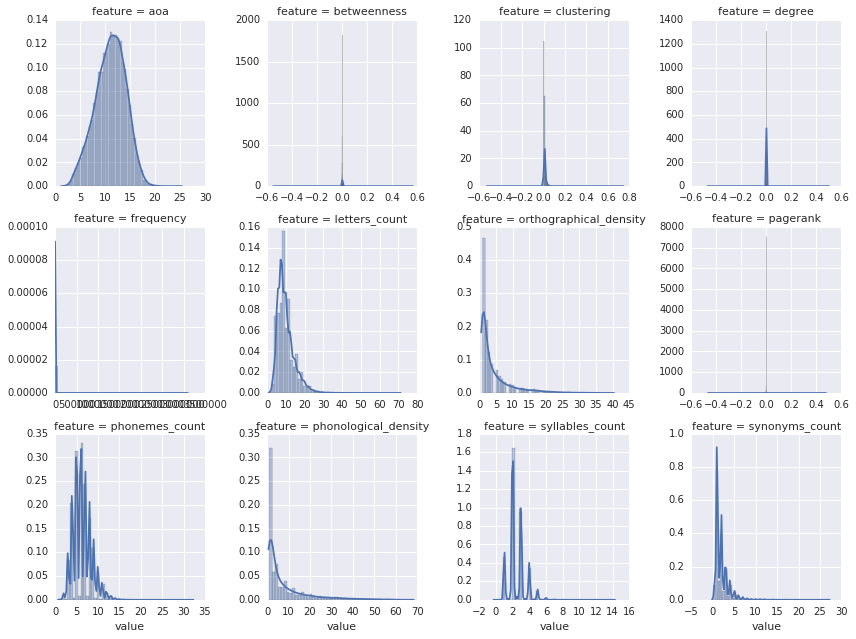

In [4]:
g = sb.FacetGrid(pd.melt(features, id_vars='word', var_name='feature'),
                 col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sb.distplot, 'value')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_distributions-raw'),
                  bbox_inches='tight', dpi=300)

Conclusion: **all features except `aoa`, `letters_count`, `phonemes_count`, `syllables_count`, and `synonyms_count` should be translated to log** so we can see better.

The result is the following.

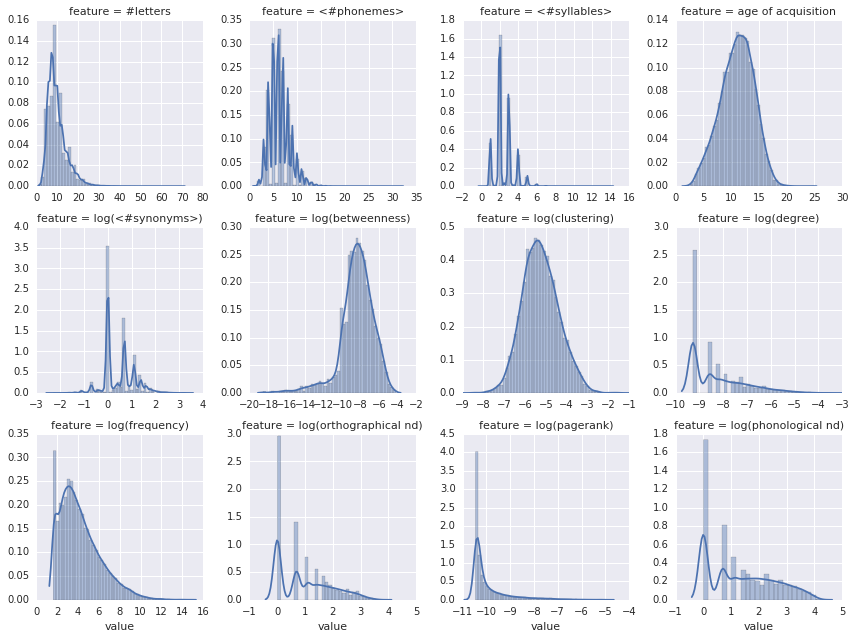

In [5]:
g = sb.FacetGrid(pd.melt(tfeatures, id_vars='word', var_name='feature'),
                 col='feature', col_wrap=4, sharex=False, sharey=False)
g.map(sb.distplot, 'value')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_distributions-transformed'),
                  bbox_inches='tight', dpi=300)

Which is quite a bit more readable.

Now reducing to the features we expose in the paper

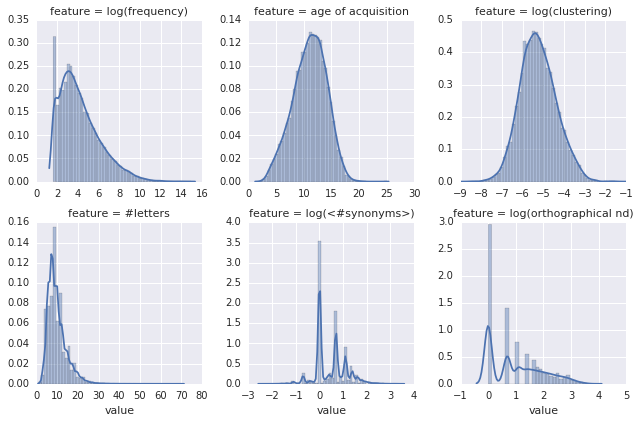

In [6]:
g = sb.FacetGrid(pd.melt(tfeatures[PAPER_FEATURE_NAMES_V2 + ['word']],
                         id_vars='word', var_name='feature'),
                 col='feature', col_wrap=3, sharex=False, sharey=False)
g.map(sb.distplot, 'value')
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_distributions-transformed'),
                  bbox_inches='tight', dpi=300)

## 3 Feature correlations

First the brute interactions between all features.

**CAVEAT**: because of [seaborn#407](https://github.com/mwaskom/seaborn/issues/407), the interactions are computed on the set of words where *all* features are defined (i.e. we drop all rows where any feature is NaN). So this graph is a preview, and not something publishable.

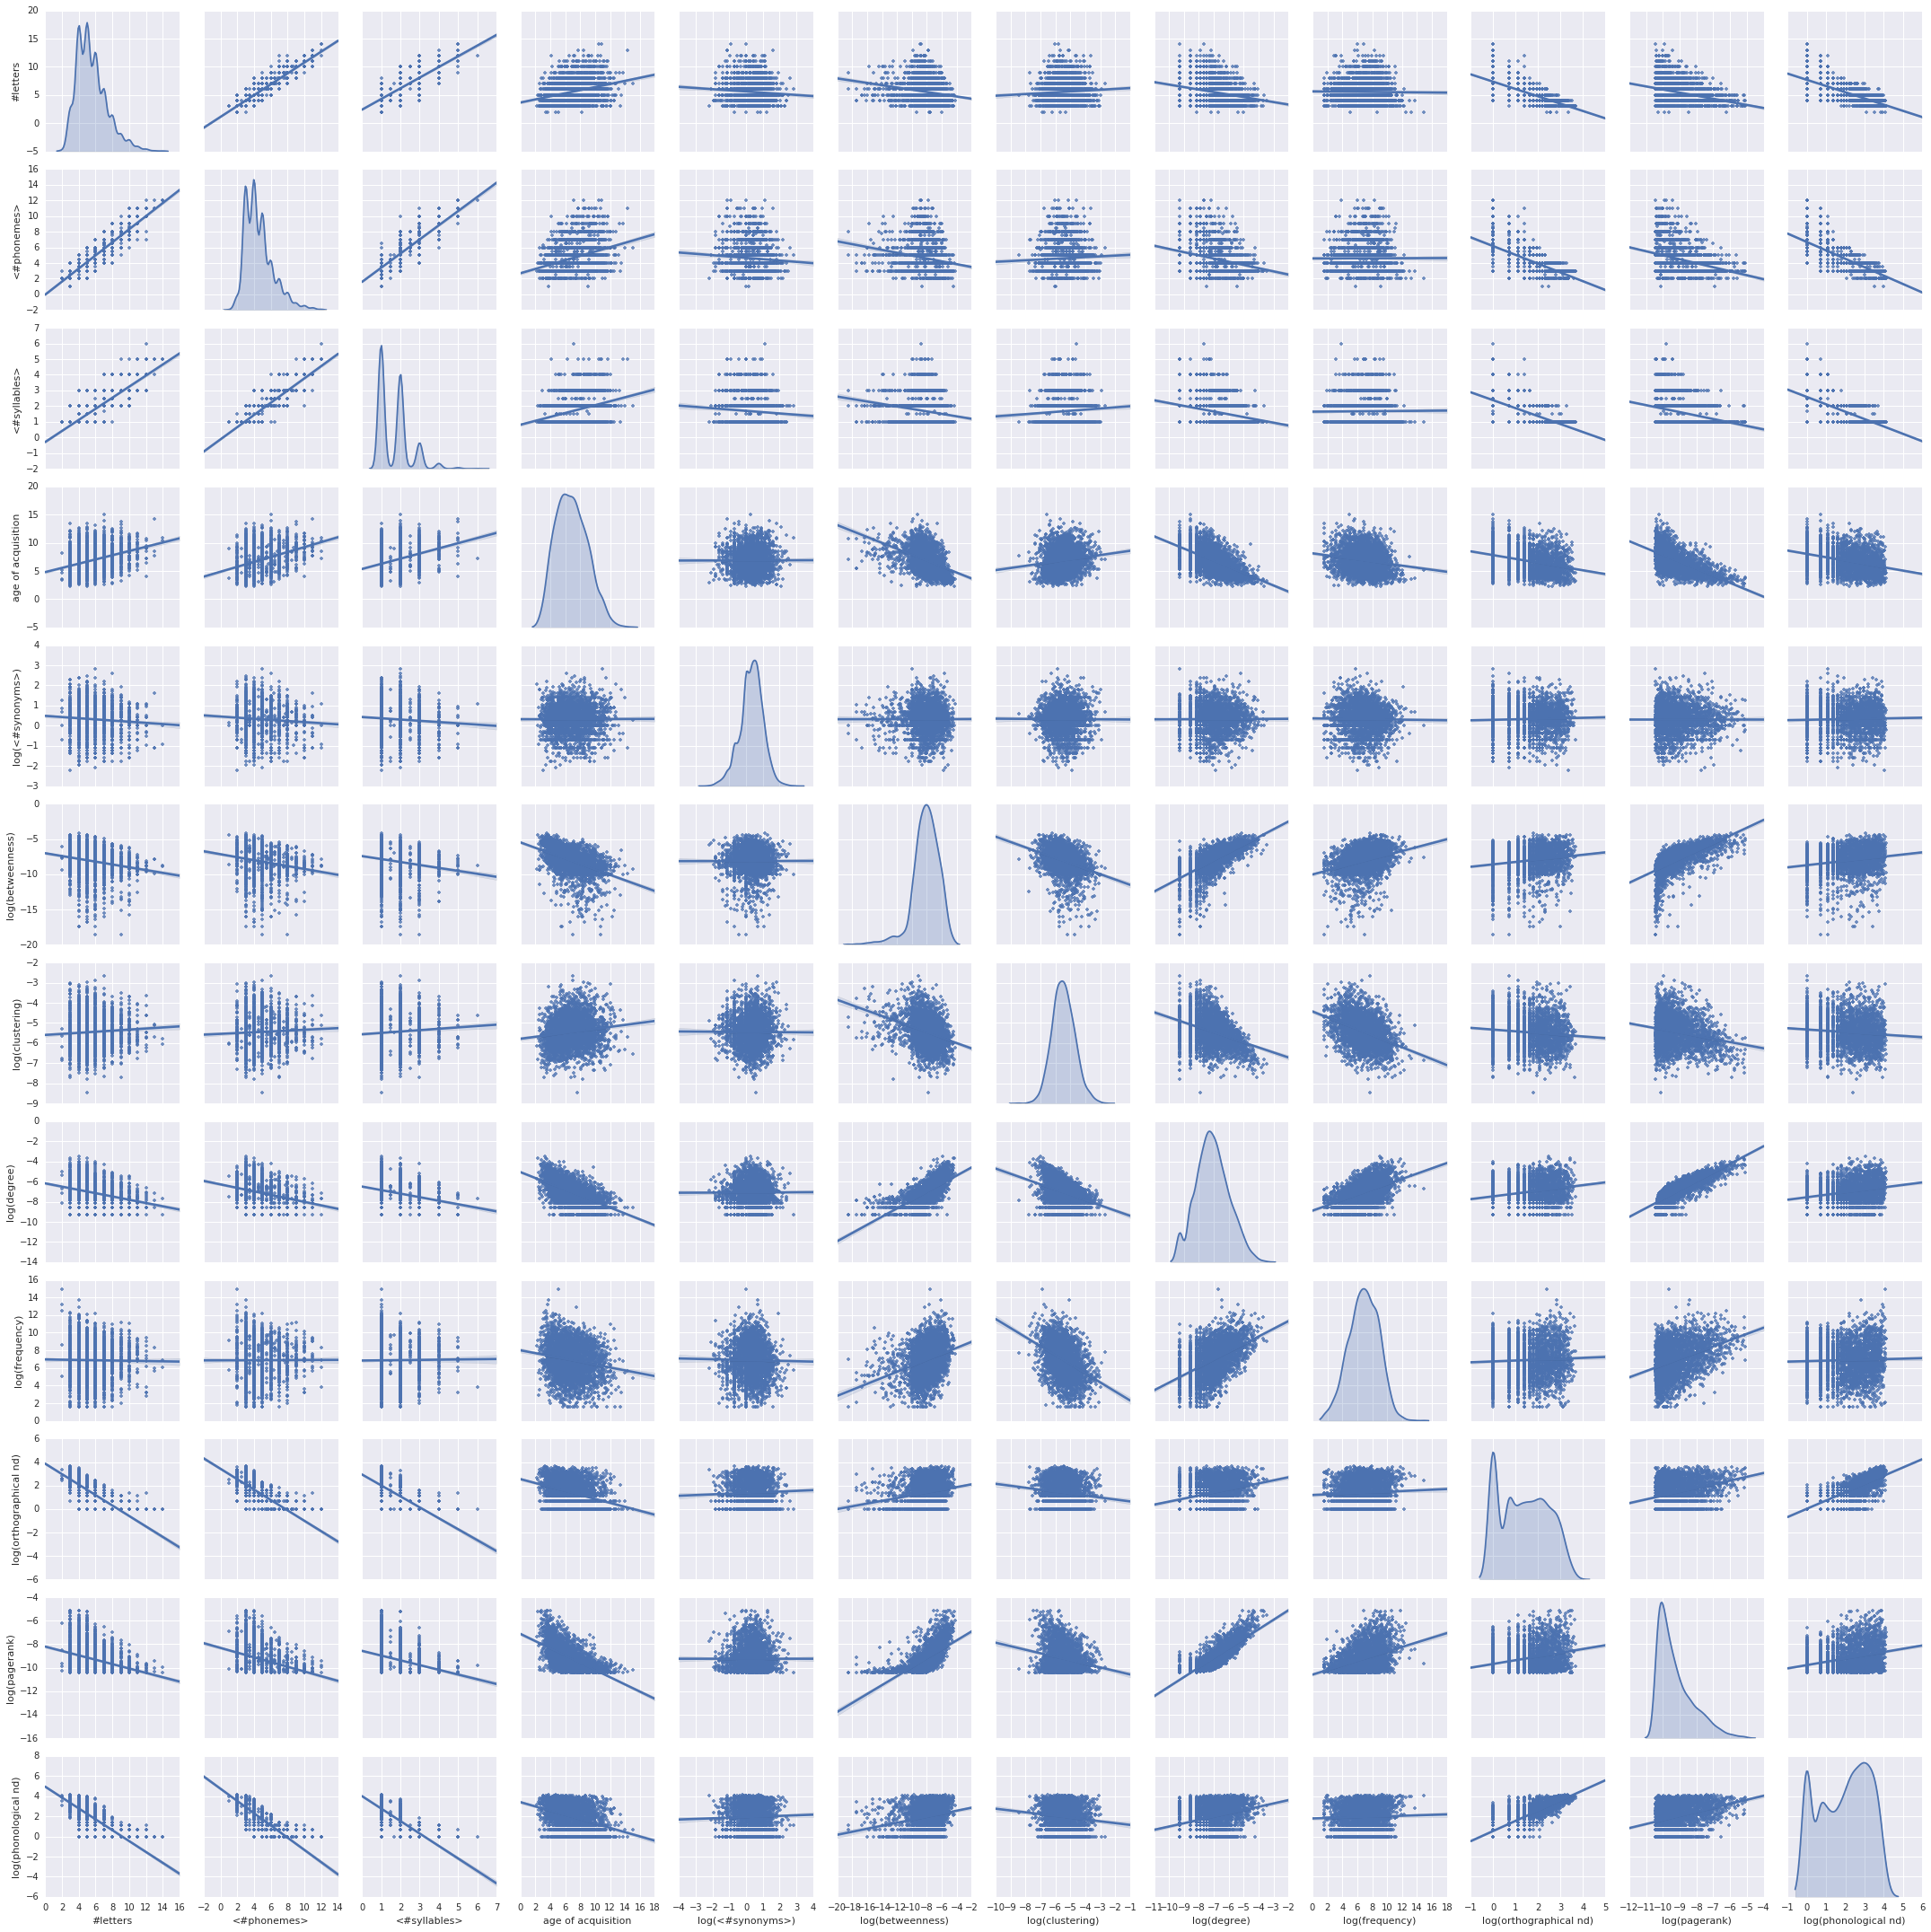

In [7]:
g = sb.pairplot(tfeatures.dropna(), kind='reg', markers="+",
                diag_kind="kde", diag_kws=dict(shade=True))
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('all-feature_interactions'),
                  bbox_inches='tight', dpi=300)

Now reducing to the features we expose in the paper

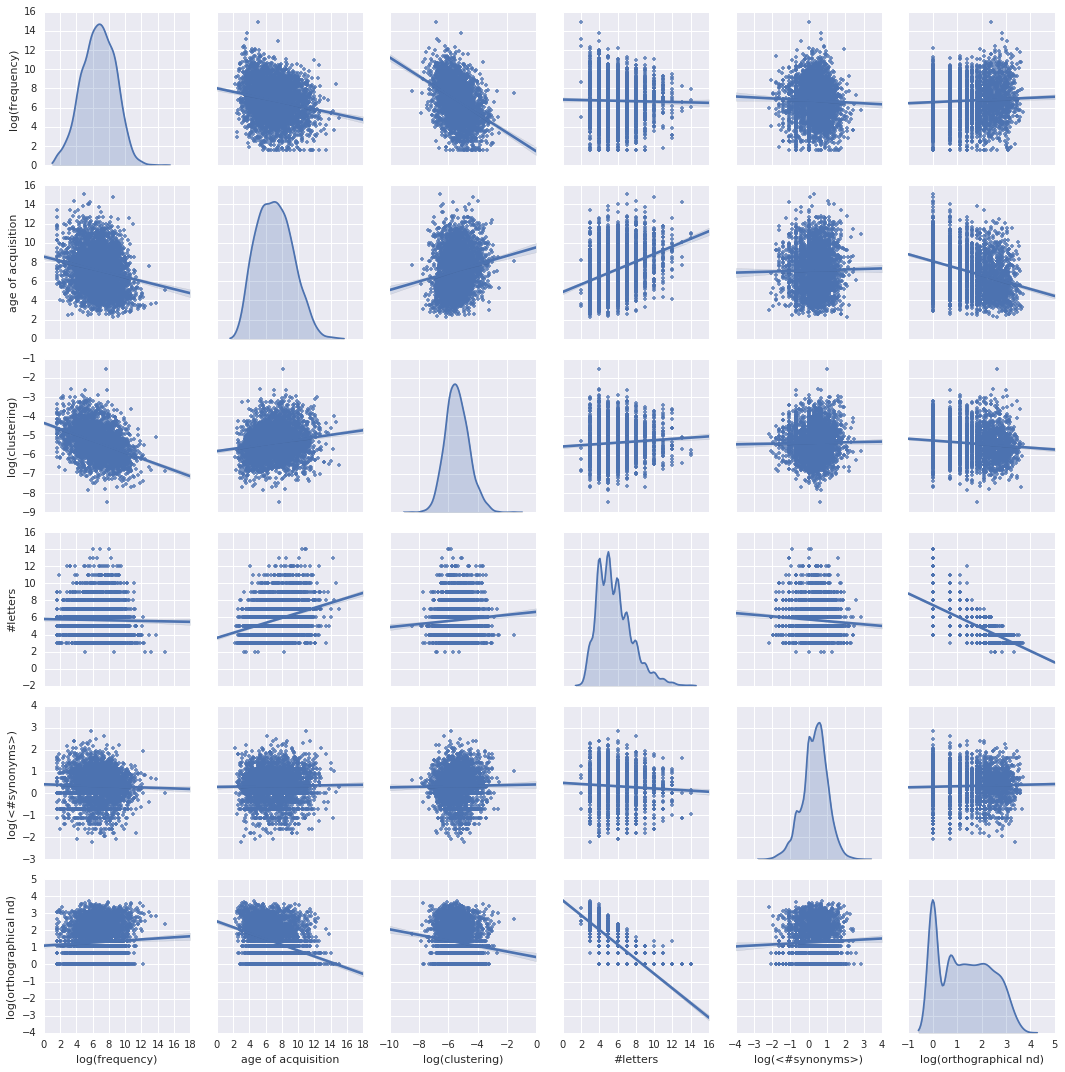

In [8]:
g = sb.pairplot(tfeatures[PAPER_FEATURE_NAMES_V2].dropna(), kind='reg', markers="+",
                diag_kind="kde", diag_kws=dict(shade=True))
if SAVE_FIGURES:
    g.fig.savefig(settings.FIGURE.format('paper-feature_interactions'),
                  bbox_inches='tight', dpi=300)

### 3.1 Pretty-plotting function for correlations

In [9]:
# Imports
from matplotlib import cm
from matplotlib.patches import Ellipse

def pretty_plot_correlations(data, scaling=1.0, cor_fontsize=30.0, label_fontsize=35.0):
    """Pretty-plot a correlation matrix.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the variables for which to plot the correlation matrix.
    scaling : float, optional
        Scaling factor for the whole figure; for instance `2.0` would
        create a figure twice as big (for better resolution when saving);
        defaults to 1.0.
    cor_fontsize : float, optional
        Font size for the correlation values; defaults to 30.0.
    label_fontsize : float, optional
        Font size for the labels; defaults to 35.0.
    
    """
    
    # Some layout definitions.
    ellipse_lwidth = 1.5
    sep_crop = 0.2
    
    # Precompute useful values.
    correlations = data.corr()
    n_features = len(correlations)
    lims = np.linspace(0, 1, n_features + 1)
    step = 1 / n_features
    xs = lims[:-1] + step / 2
    esize = 0.98 * step
    
    # Create our figure.
    fig, ax = plt.subplots(figsize=(4 * scaling, 4 * scaling))
    
    # For all couples...
    for i in range(n_features):
        for j in range(n_features):
            # ...compute coordinates...
            x = xs[j]
            y = 1 - xs[i]
            cor = correlations.iloc[i, j]
            
            if i < j:
                # ...plot an Ellipse...
                color = cm.bwr((1 - cor) / 2)
                ax.add_patch(Ellipse([x, y], esize, esize * (1 - abs(cor)),
                             angle=np.sign(cor) * 45, ls='solid', lw=ellipse_lwidth,
                             ec='black', fc=color, alpha=0.8))
            
            elif i > j:
                # ...or show the correlation value.
                ax.text(x, y, "{:.2f}".format(cor).rstrip("0"),
                        fontsize=cor_fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')
    
    # Add the line separators and labels.
    for i in range(n_features):
        # Line separator
        ax.plot([(i + sep_crop) * step, (i + 1 - sep_crop) * step],
                [1 - (i + 1 - sep_crop) * step, 1 - (i + sep_crop) * step],
                'k-', lw=ellipse_lwidth)
        
        # Horizontal label
        ax.text(- step / 2, 1 - step / 2 - i * step,
                correlations.columns[i], fontsize=label_fontsize,
                horizontalalignment='right', verticalalignment='center')
        
        # Vertical label
        ax.text(step / 2 + i * step, 1 + step / 2,
                correlations.columns[i], fontsize=label_fontsize, rotation='vertical',
                horizontalalignment='center', verticalalignment='bottom')
    
    # Finally, set the axis limits and hide the axis themselves.
    ax.set_xlim(- 0.1, 1.1)
    ax.set_ylim(- 0.1, 1.1)
    ax.axis('off')
    
    return fig

Now the real correlation matrix

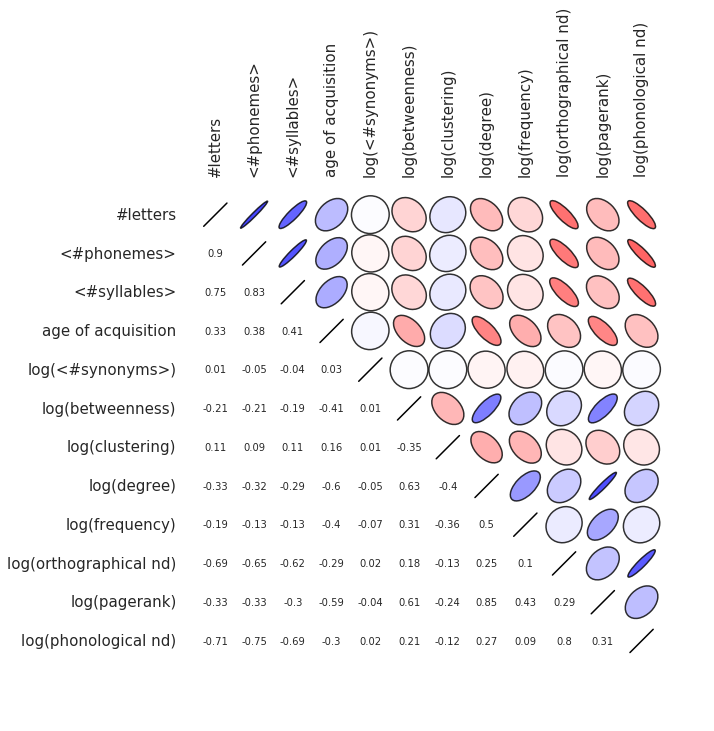

In [10]:
fig = pretty_plot_correlations(tfeatures, scaling=2.5, cor_fontsize=10, label_fontsize=15)
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-feature_correlations'),
                bbox_inches='tight', dpi=300)

Now reducing to the features we expose in the **first version** of the paper

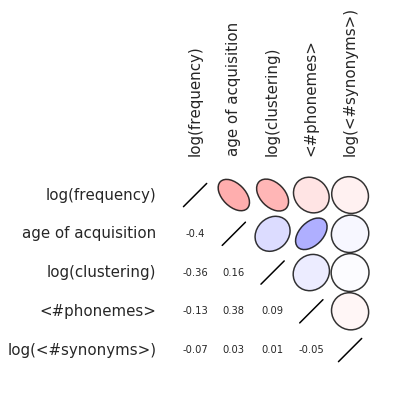

In [11]:
fig = pretty_plot_correlations(tfeatures[PAPER_FEATURE_NAMES_V1],
                               scaling=2.5 * len(PAPER_FEATURE_NAMES_V1)
                                       / len(SubstitutionFeaturesMixin.__features__),
                               cor_fontsize=10, label_fontsize=15)
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('paper-feature_correlations-v1'),
                bbox_inches='tight', dpi=300)

## 4 PCA on features

Compute PCA on word features directly. This is just exploratory since we really want to compute PCA of feature variations upon substitution (see the 'variation' notebook).

In [12]:
from sklearn.decomposition import PCA

ntfeatures = tfeatures.select_dtypes(include=[np.number]).dropna()
pca = PCA(n_components='mle')
pca.fit(ntfeatures)
pcafeatures = pca.transform(ntfeatures)

print('Variance explained with first {} components (mle-estimated):'
      .format(pca.n_components_))
print(pca.explained_variance_ratio_)

Variance explained with first 9 components (mle-estimated):
[ 0.43606509  0.23617255  0.12830728  0.07911871  0.02607531  0.0242095
  0.01896433  0.01793096  0.01481288]


In [13]:
pca.components_

array([[-0.43848659, -0.40955094, -0.17556155, -0.46879836,  0.00894917,
         0.3260381 , -0.05762326,  0.2259955 ,  0.18250707,  0.23469543,
         0.22791327,  0.29714174],
       [-0.38112358, -0.35546628, -0.14903149,  0.24633414,  0.01723628,
        -0.38251522,  0.10725434, -0.23697991, -0.56347421,  0.17015376,
        -0.18672401,  0.22337938],
       [ 0.20702003,  0.15494473,  0.05680164, -0.60198818, -0.01010635,
         0.16020625,  0.09746874,  0.01475416, -0.71053598, -0.09695175,
         0.07551147, -0.10986179],
       [-0.04925148, -0.01541159, -0.00080798,  0.55583962,  0.01077732,
         0.75413234, -0.0537365 ,  0.10417205, -0.31282666, -0.01057885,
         0.08848548, -0.00227308],
       [ 0.33293025,  0.31003703,  0.02945197, -0.01968105, -0.13896373,
         0.0642801 , -0.25735997, -0.13567709, -0.02215956,  0.55950459,
        -0.16064146,  0.58681542],
       [-0.1021849 , -0.10863442, -0.02371462, -0.21450578,  0.05231206,
         0.35911489, -

A quick look at the first two components

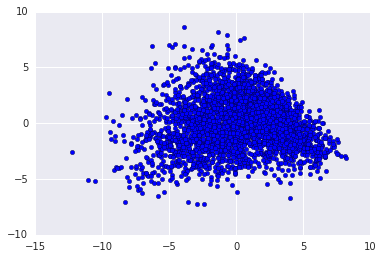

In [14]:
plt.scatter(pcafeatures[:,0], pcafeatures[:,1])

## 5 Feature Selection

Compute centered and normalised feature values so that the clustering works better.

In [15]:
nfeatures = tfeatures.select_dtypes(include=[np.number])
cfeatures = (nfeatures - nfeatures.mean()) / nfeatures.std()

Compute clustering of features. Tinkering with different linkage and n_cluster values shows this result is quite robust.

In [16]:
from sklearn import cluster

agglo = cluster.FeatureAgglomeration(n_clusters=6)
agglo.fit(cfeatures.dropna())

groups = dict((n, []) for n in set(agglo.labels_))
for i, feature in enumerate(cfeatures.columns):
    groups[agglo.labels_[i]].append(feature)

groups

{0: ['log(betweenness)', 'log(degree)', 'log(pagerank)'],
 1: ['#letters', '<#phonemes>', '<#syllables>', 'age of acquisition'],
 2: ['log(orthographical nd)', 'log(phonological nd)'],
 3: ['log(clustering)'],
 4: ['log(frequency)'],
 5: ['log(<#synonyms>)']}

So in our original selection, we had the right groups except for including AoA and \#letters separately, and not including the degree (pooled with clustering in the end).

Now if we replot correlations with a selection from this grouping, we get:

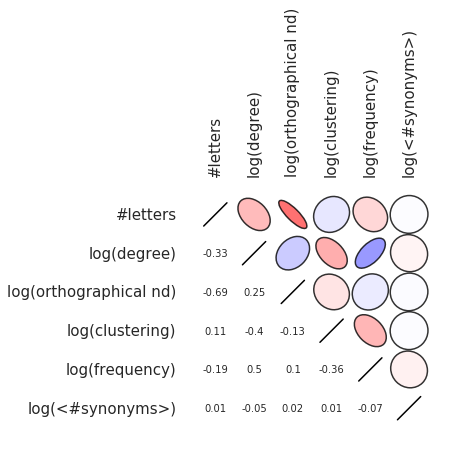

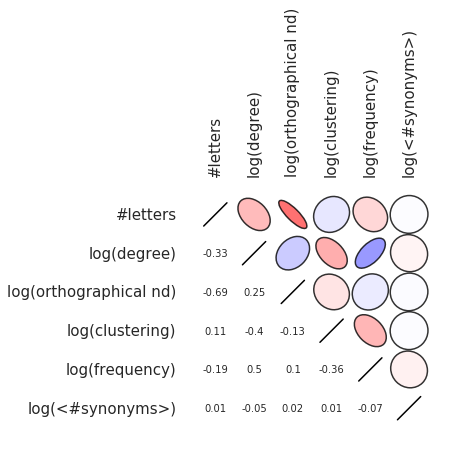

In [17]:
selected_feature_names = ['#letters', 'log(degree)', 'log(orthographical nd)',
                          'log(clustering)', 'log(frequency)', 'log(<#synonyms>)']
pretty_plot_correlations(tfeatures[selected_feature_names],
                         scaling=2.5 * len(selected_feature_names)
                                 / len(SubstitutionFeaturesMixin.__features__),
                         cor_fontsize=10, label_fontsize=15)

Now given that:
* \#letters and orthographical neighbourhood density correlate a lot, we could drop the latter
* degree and frequency also correlate a lot, we could drop the former
* I'm interested in seeing age-of-acquisition independently, we could reintroduce it

...and we'd get back to our original set of features. So in conclusion, it seems fair to keep our original set of features and maybe add orthographical neighbourhood density. We'd get:

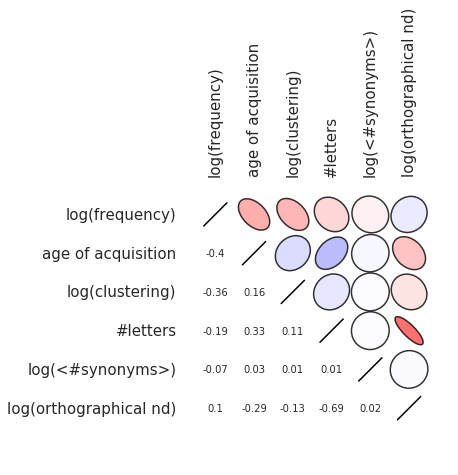

In [18]:
fig = pretty_plot_correlations(tfeatures[PAPER_FEATURE_NAMES_V2],
                               scaling=2.5 * len(PAPER_FEATURE_NAMES_V2)
                                       / len(SubstitutionFeaturesMixin.__features__),
                               cor_fontsize=10, label_fontsize=15)
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('paper-feature_correlations-v2'),
                bbox_inches='tight', dpi=300)